In [9]:
!pip install torch torchvision albumentations tqdm tensorboard -q

# 2. Imports
import os, cv2, numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.segmentation import deeplabv3_resnet50

# 3. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 4. Đặt đường dẫn tới 4 folder của bạn
BASE = '/content/drive/MyDrive'
TRAIN_IMG_DIR  = os.path.join(BASE, 'Training_Data')
TRAIN_MASK_DIR = os.path.join(BASE, 'Training_GroundTruth')
VAL_IMG_DIR    = os.path.join(BASE, 'Test_Data')
VAL_MASK_DIR   = os.path.join(BASE, 'Test_GroundTruth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Paired 900 samples (out of 900 images, 900 masks)
Paired 379 samples (out of 379 images, 379 masks)
Train samples: 900
Val   samples: 379


Validate: 100%|██████████| 379/379 [04:46<00:00,  1.32it/s]


Epoch 1 | Train Loss: 0.2725 | Val Loss: 0.2339
        IoU: 0.7734 | Dice: 0.7263 | Prec: 0.8271 | Rec: 0.9379 | F1: 0.8580



Validate: 100%|██████████| 379/379 [00:55<00:00,  6.89it/s]


Epoch 2 | Train Loss: 0.1803 | Val Loss: 0.1543
        IoU: 0.8427 | Dice: 0.8159 | Prec: 0.9011 | Rec: 0.9374 | F1: 0.9095



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.90it/s]


Epoch 3 | Train Loss: 0.1380 | Val Loss: 0.1490
        IoU: 0.8121 | Dice: 0.8397 | Prec: 0.8443 | Rec: 0.9615 | F1: 0.8886



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.92it/s]


Epoch 4 | Train Loss: 0.1335 | Val Loss: 0.1309
        IoU: 0.8406 | Dice: 0.8515 | Prec: 0.8919 | Rec: 0.9451 | F1: 0.9079



Validate: 100%|██████████| 379/379 [00:55<00:00,  6.87it/s]


Epoch 5 | Train Loss: 0.1121 | Val Loss: 0.1388
        IoU: 0.8285 | Dice: 0.8555 | Prec: 0.8743 | Rec: 0.9479 | F1: 0.8986



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.91it/s]


Epoch 6 | Train Loss: 0.1049 | Val Loss: 0.1337
        IoU: 0.8363 | Dice: 0.8728 | Prec: 0.9442 | Rec: 0.8880 | F1: 0.9045



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.94it/s]


Epoch 7 | Train Loss: 0.1023 | Val Loss: 0.1173
        IoU: 0.8472 | Dice: 0.8821 | Prec: 0.9058 | Rec: 0.9382 | F1: 0.9121



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.90it/s]


Epoch 8 | Train Loss: 0.0859 | Val Loss: 0.1199
        IoU: 0.8400 | Dice: 0.8818 | Prec: 0.9134 | Rec: 0.9232 | F1: 0.9077



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.89it/s]


Epoch 9 | Train Loss: 0.0854 | Val Loss: 0.1144
        IoU: 0.8462 | Dice: 0.8866 | Prec: 0.9396 | Rec: 0.8995 | F1: 0.9095



Validate: 100%|██████████| 379/379 [00:54<00:00,  6.93it/s]


Epoch 10 | Train Loss: 0.0799 | Val Loss: 0.1187
        IoU: 0.8403 | Dice: 0.8870 | Prec: 0.9475 | Rec: 0.8867 | F1: 0.9060



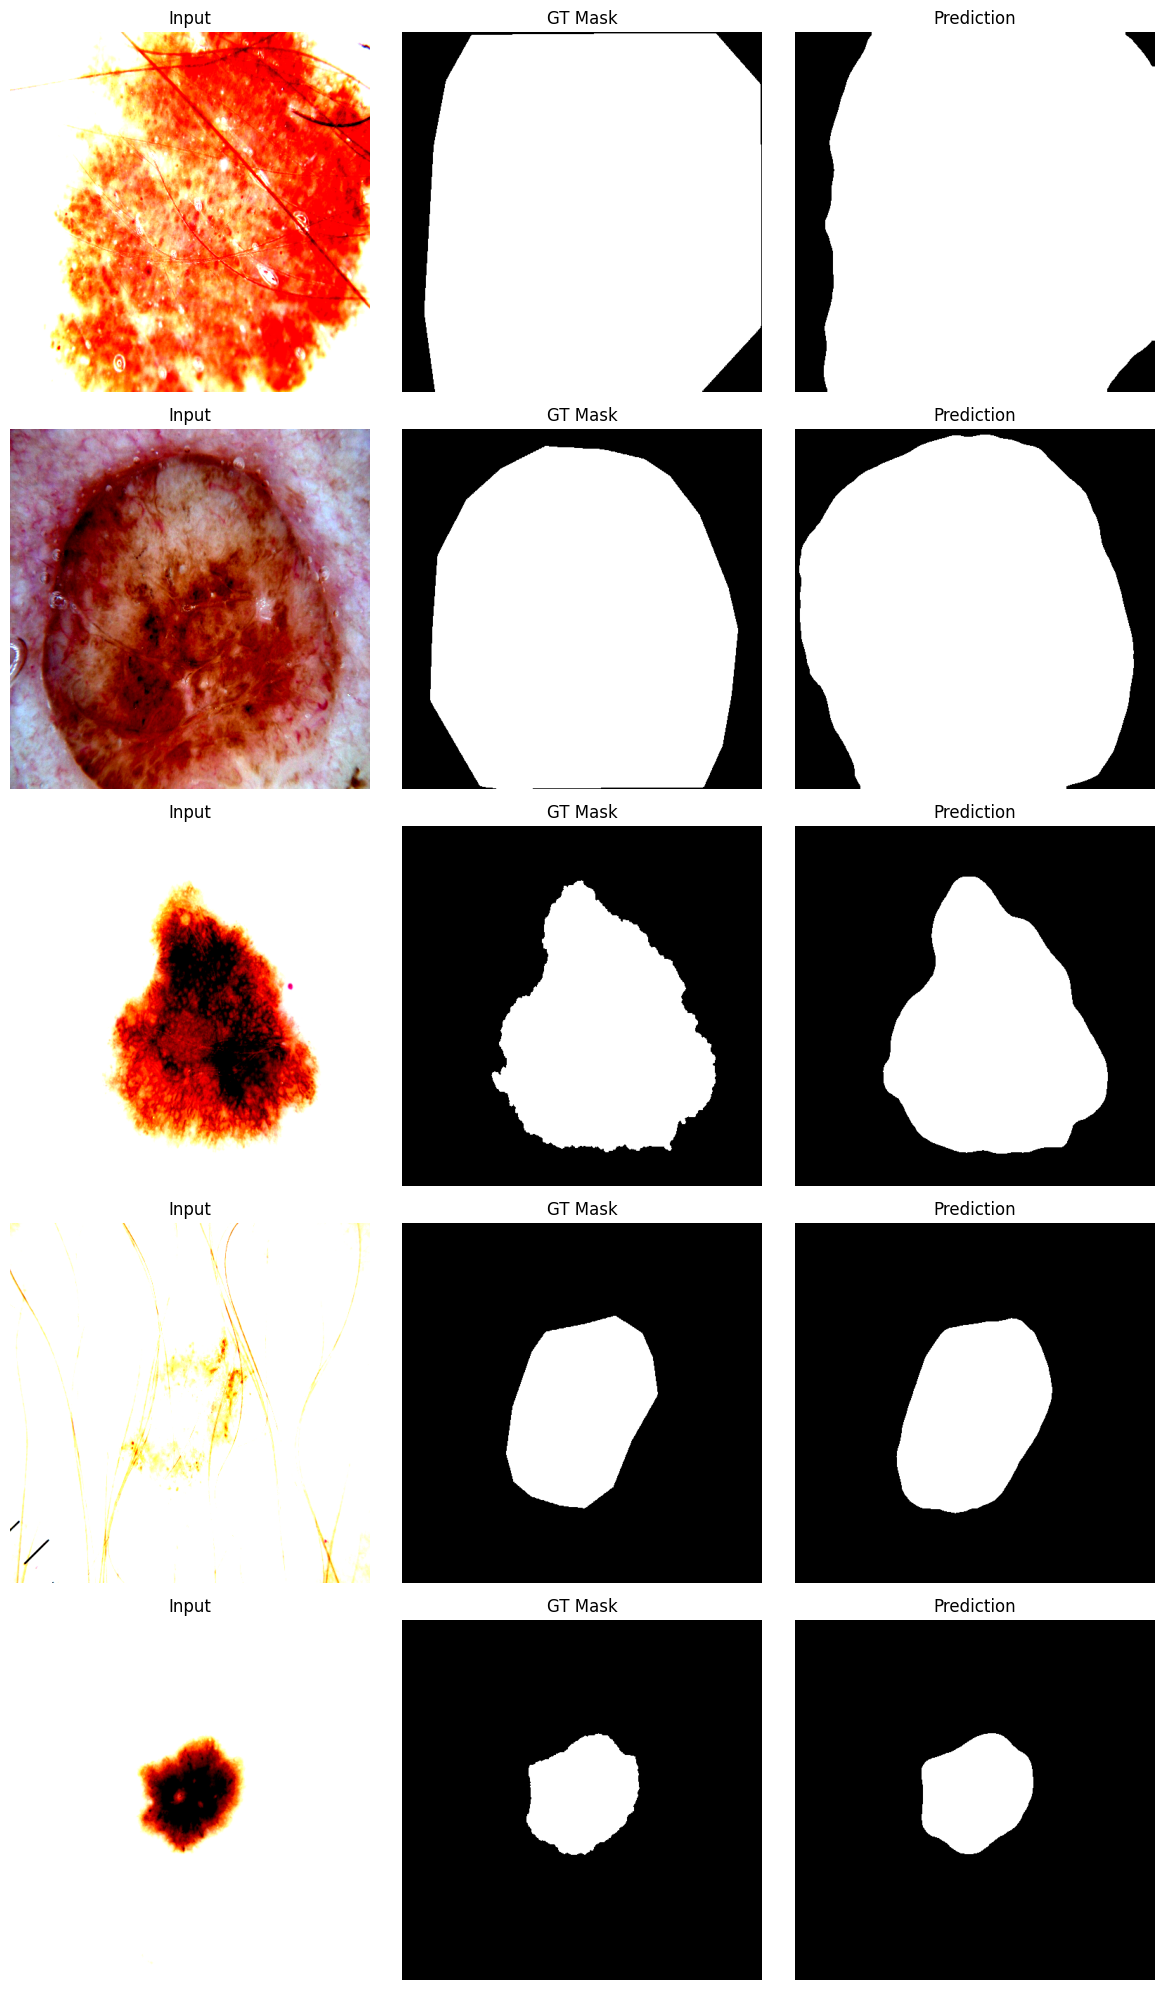

Visualization complete.


In [11]:

# 5. Tự động ghép đôi ảnh ↔ mask bằng prefix matching
def make_pairs(img_dir, mask_dir):
    img_paths = sorted(glob(os.path.join(img_dir, '*')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*')))
    paired = []
    for img_p in img_paths:
        img_base = os.path.splitext(os.path.basename(img_p))[0]
        match = [m for m in mask_paths if os.path.splitext(os.path.basename(m))[0].startswith(img_base)]
        if match:
            paired.append((img_p, match[0]))
    print(f"Paired {len(paired)} samples (out of {len(img_paths)} images, {len(mask_paths)} masks)")
    return paired

train_pairs = make_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_pairs   = make_pairs(VAL_IMG_DIR,   VAL_MASK_DIR)

# 6. Dataset sử dụng list pairs
class ISICDataset(Dataset):
    def __init__(self, pairs, transforms=None):
        self.pairs = pairs
        self.transforms = transforms
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            raise ValueError(f"Cannot read {img_path} or {mask_path}")
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = (mask > 127).astype('float32')
        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.unsqueeze(0)

# 7. Transforms
train_transforms = A.Compose([
    A.Resize(512,512), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2),
    A.Normalize(), ToTensorV2(),
])
val_transforms = A.Compose([
    A.Resize(512,512), A.Normalize(), ToTensorV2(),
])

# 8. Build Datasets & DataLoaders
train_ds = ISICDataset(train_pairs, transforms=train_transforms)
val_ds   = ISICDataset(val_pairs,   transforms=val_transforms)
print("Train samples:", len(train_ds))
print("Val   samples:", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0)

# 9. Model, Loss, Optimizer, TensorBoard
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deeplabv3_resnet50(pretrained=True, progress=True)
model.classifier[-1]     = nn.Conv2d(256, 1, kernel_size=1)
model.aux_classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

bce = nn.BCEWithLogitsLoss()
def dice_score(pred, target, smooth=1e-6):
    pred_flat   = torch.sigmoid(pred).view(-1)
    target_flat = target.view(-1)
    inter = (pred_flat * target_flat).sum()
    return ((2*inter + smooth) / (pred_flat.sum() + target_flat.sum() + smooth))

# Metrics: Precision, Recall, F1
def metrics(pred, mask):
    pred = pred.view(-1)
    mask = mask.view(-1)
    TP = (pred * mask).sum().item()
    FP = (pred * (1-mask)).sum().item()
    FN = ((1-pred) * mask).sum().item()
    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    return precision, recall, f1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir='runs/ISIC_DeepLabV3')

# 10. Training & Validation loop with detailed logging
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    # Training
    model.train()
    train_loss = 0.0
    for step, (imgs, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} Train")):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)['out']
        loss = bce(out, masks) * 0.5 + (1 - dice_score(out, masks)) * 0.5
        loss.backward(); optimizer.step()
        train_loss += loss.item()
        if (step+1) % 20 == 0:
            writer.add_scalar('Train/Batch Loss', loss.item(), epoch*len(train_loader)+step)
    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar('Train/Epoch Loss', avg_train_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0.0
    iou_list, dice_list, prec_list, rec_list, f1_list = [], [], [], [], []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validate"):
            imgs, masks = imgs.to(device), masks.to(device)
            out  = model(imgs)['out']
            loss = bce(out, masks) * 0.5 + (1 - dice_score(out, masks)) * 0.5
            val_loss += loss.item()
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).float()
            inter = (pred * masks).sum((1,2,3))
            union = pred.sum((1,2,3)) + masks.sum((1,2,3)) - inter
            iou  = ((inter + 1e-6) / (union + 1e-6)).item()
            dice = dice_score(out, masks).item()
            p, r, f1 = metrics(pred, masks)
            iou_list.append(iou)
            dice_list.append(dice)
            prec_list.append(p)
            rec_list.append(r)
            f1_list.append(f1)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou      = np.mean(iou_list)
    avg_dice     = np.mean(dice_list)
    avg_prec     = np.mean(prec_list)
    avg_rec      = np.mean(rec_list)
    avg_f1       = np.mean(f1_list)
    writer.add_scalar('Val/Epoch Loss',   avg_val_loss, epoch)
    writer.add_scalar('Val/IoU',          avg_iou,      epoch)
    writer.add_scalar('Val/Dice',         avg_dice,     epoch)
    writer.add_scalar('Val/Precision',    avg_prec,     epoch)
    writer.add_scalar('Val/Recall',       avg_rec,      epoch)
    writer.add_scalar('Val/F1',           avg_f1,       epoch)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"        IoU: {avg_iou:.4f} | Dice: {avg_dice:.4f} | Prec: {avg_prec:.4f} | Rec: {avg_rec:.4f} | F1: {avg_f1:.4f}\n")

# 11. Kết thúc và xem TensorBoard
# Chạy trong terminal Colab:
# !tensorboard --logdir runs/ISIC_DeepLabV3 --bind_all

# 12. Visualize Predictions on Validation Set
import random
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, device, n=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, mask = dataset[idx]
            inp = img.unsqueeze(0).to(device)
            out = torch.sigmoid(model(inp)['out'])[0,0].cpu().numpy()
            pred_mask = (out > 0.5).astype(np.uint8)
            axes[i,0].imshow(img.permute(1,2,0).cpu());          axes[i,0].axis('off'); axes[i,0].set_title('Input')
            axes[i,1].imshow(mask[0].cpu(), cmap='gray');       axes[i,1].axis('off'); axes[i,1].set_title('GT Mask')
            axes[i,2].imshow(pred_mask, cmap='gray');           axes[i,2].axis('off'); axes[i,2].set_title('Prediction')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_ds, device, n=5)
print('Visualization complete.')